<a href="https://colab.research.google.com/github/Aditya11013/machine-learning/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    def __repr__(self):
        return f'value(data={self.data})'
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')
        def _backward():
          self.grad += 1.0*out.grad
          other.grad += 1.0*out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')
        def _backward():
          self.grad += (other.data)*out.grad
          other.grad += (self.data)*out.grad
        out._backward = _backward

        return out
    def __neg__(self):
      return self*-1
    def __sub__(self,other):
      return self + (-other)
    def __pow__(self,other):
      assert isinstance(other,(int,float))
      out = Value(self.data**other,(self,),f'**{other}')
      def _backward():
        self.grad+= other * (self.data **(other-1))
      out._backward = _backward
      return out
    def __radd__(self, other):
      return self.__add__(other)

    def __rmul__(self,other):
      return self*other

    def __truediv__(self,other):
      # other = other if isinstance(other, Value) else Value(other)
      return self*other**-1

    def tanh(self):
      x =self.data
      t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
      out = Value(t,(self,),'tanh')
      def _backward():
        self.grad += (1-t**2)*out.grad
      out._backward = _backward
      return out
    def exp(self):
      x = self.data
      out = Value(math.exp(x),(self,),'exp')
      def _backward():
        self.grad = out.data*out.grad
      out._backward = _backward
      return out
    def backward(self):
      topo = []
      nodes=set()
      def build(v):
        if v not in nodes:
          nodes.add(v)
          for child in v._prev:
            build(child)
          topo.append(v)
      build(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()


In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
a = Value(2.0,label = 'a')
b= Value(4.0,label='b')
c = a+b ;c.label = 'c'
c

value(data=6.0)

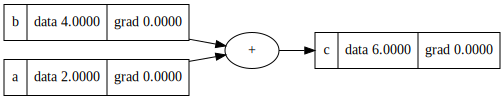

In [ ]:
draw_dot(c)

In [ ]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0 , label='x2')

w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0 , label = 'w2')

b = Value(6.8813735870195432 , label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1+x2w2;x1w1x2w2.label = 'x1w1+x2w2'

n = x1w1x2w2+b ; n.label='n'

e = (2*n).exp()
o = (e-1)/(e+1)
o.label='o'
# o = n.tanh() ;
# o.grad = 1.0

In [ ]:
o.backward()

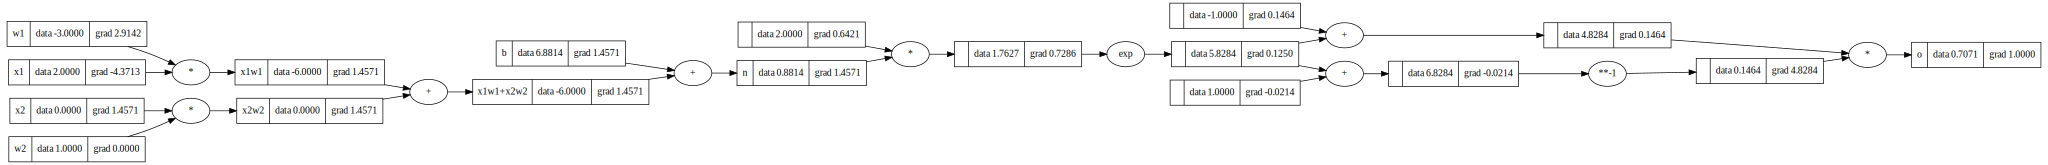

In [ ]:
draw_dot(o)

In [ ]:
a = Value(-2.0 , label = 'a')
b = a+a ; b.label = 'b'
b

value(data=-4.0)

In [ ]:
b.backward()

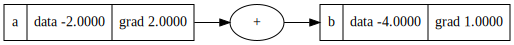

In [ ]:
draw_dot(b)

In [ ]:
a = Value(2.0)
b =Value(5.0)
c = a.exp()
c

In [45]:
class Neuron:
  def __init__(self,nin):
    self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(np.random.uniform(-1,1))
  def __call__(self,x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
    out = act.tanh()
    return out
  def parameters(self):
    return self.w+[self.b]

class Layer:
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(sz)-1)]
  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layera for p in layer.parameters()]

In [43]:
x = [2.0,3.0]
n = MLP(2,[4,4,3])
n(x)

[value(data=-0.6559073999226513),
 value(data=-0.8775411636566539),
 value(data=-0.5674362270747351)]

In [38]:
x+[2]

[2.0, 3.0, 2]